In [19]:
# %%
import pandas as pd
import numpy as np
import mlextend
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
from scipy.special import comb
from scipy.stats import binom
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import clone,BaseEstimator
from sklearn.metrics import roc_curve,auc,roc_auc_score

ModuleNotFoundError: No module named 'mlextend'

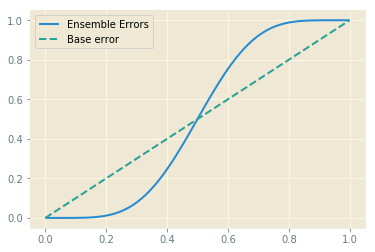

In [2]:
# %%
error_range = np.arange(0.0,1.01,0.01)
n_classifier = 11
np.ceil(n_classifier/2)
ens_errors=binom.sf(n_classifier - np.ceil(n_classifier/2),n_classifier,error_range)
plt.plot(error_range,ens_errors,linewidth=2,label= 'Ensemble Errors')
plt.plot(error_range,error_range,linestyle = '--',label = 'Base error')
plt.legend(loc='upper left')
plt.show()

In [3]:
iris = datasets.load_iris()
X,y = iris.data[50:,[1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.5,random_state = 1,stratify =y)

### Classfying individual 

In [4]:
clf1 = LogisticRegression(penalty='l2',C=0.001,random_state=1,solver='lbfgs')
clf2 = DecisionTreeClassifier(max_depth=1,random_state=1)
clf3 = KNeighborsClassifier(n_neighbors=1)
pipeline1 = Pipeline([['sc1',StandardScaler()],['clf',clf1]])
pipeline3 = Pipeline([['sc2',StandardScaler()],['clf',clf3]])
clf_labels = ['Logistic_Regression','DecisionTree','KNeighborsClassifier']

for label,clf in zip(clf_labels,[pipeline1,clf2,pipeline3]):

    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print('ROC Score for [%s] %0.2f +/- %0.2f'% (label,scores.mean(),scores.std()))

ROC Score for [Logistic_Regression] 0.87 +/- 0.17
ROC Score for [DecisionTree] 0.89 +/- 0.16
ROC Score for [KNeighborsClassifier] 0.88 +/- 0.15


In [5]:
class MajorityVoteClassifier_sush(BaseEstimator):
    """
    Paramaters
    ---------------------------
    classifiers: array-like,shape = [n_classifiers]
    vote: str,{'classlabel','probability'}
    defaults to 'classlabel'
    weights: array-like,shape = [n_classifiers]
    classifers are weigthed accordingle
    """
    def __init__(self,classifiers,vote = 'classlabel',weights = None):
        self.classifiers = classifiers
        self.vote = vote
        self.weights = weights
        return None
    
    def fit(self,X,y):
        self.labelencoders_ = LabelEncoder()
        self.labelencoders_.fit(y)
        self.classes_ = self.labelencoders_.classes_
        y = self.labelencoders_.transform(y)
        self.classifiers_ = []
        for clf in self.classifiers:
            self.classifiers_.append(clone(clf).fit(X,y))
        return self
    def predict(self,X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            _class_array=np.asarray([clf.predict(X) for clf in self.classifiers_])
            _min_classifiers = np.max(_class_array) + 1

            maj_vote=np.argmax(np.apply_along_axis(np.bincount, axis=1, arr= _class_array.T,
                                          minlength =_min_classifiers,weights=self.weights),axis=1)
            maj_vote=self.labelencoders_.inverse_transform(maj_vote)
        return maj_vote
    def predict_proba(self,X):
        _prob_array=np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        average_prob = np.average(_prob_array,axis=0,weights=self.weights)
        return average_prob

In [6]:
mv_clf=MajorityVoteClassifier_sush(classifiers=[pipeline1,clf2,pipeline3])
clf_labels = ['Logistic_Regression','DecisionTree','KNeighborsClassifier','Maj Voting']
for label,clf in zip(clf_labels,[pipeline1,clf2,pipeline3,mv_clf]):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print('ROC Score for [%s] %0.2f +/- %0.2f'% (label,scores.mean(),scores.std()))

ROC Score for [Logistic_Regression] 0.87 +/- 0.17
ROC Score for [DecisionTree] 0.89 +/- 0.16
ROC Score for [KNeighborsClassifier] 0.88 +/- 0.15
ROC Score for [Maj Voting] 0.93 +/- 0.11


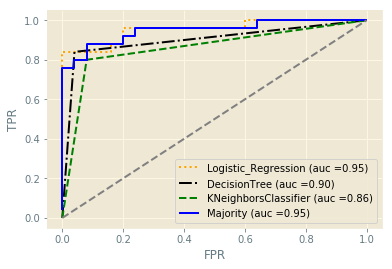

In [7]:
clf1 = LogisticRegression(penalty='l2',C=0.001,random_state=1,solver='lbfgs')
clf2 = DecisionTreeClassifier(max_depth=1,random_state=1)
clf3 = KNeighborsClassifier(n_neighbors=1)
pipeline1 = Pipeline([['sc1',StandardScaler()],['clf',clf1]])
pipeline3 = Pipeline([['sc2',StandardScaler()],['clf',clf3]])
clf_labels = ['Logistic_Regression','DecisionTree','KNeighborsClassifier','Majority']
mv_clf=MajorityVoteClassifier_sush(classifiers=[pipeline1,clf2,pipeline3])
colors = ['orange','black','green','blue']
linestyles = [':','-.','--','-']
lst_classifiers = [pipeline1,clf2,pipeline3,mv_clf]
i=0
for clf,lbl,clr,ls in zip(lst_classifiers,clf_labels,colors,linestyles):
    clf.fit(X_train,y_train)
    y_pred = clf.predict_proba(X_test)
    fpr,tpr, thresholds = roc_curve(y_test,y_pred[:,1])
    plt.plot(fpr,tpr,color=clr,linestyle= ls,label= '%s (auc =%0.2f)'%(lbl,roc_auc_score(y_test,y_pred[:,1])))
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],linestyle = '--',color='gray')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [17]:
from itertools import product
for i in product([0, 1,2], [0, 1]):
    print(i)

(0, 0)
(0, 1)
(1, 0)
(1, 1)
(2, 0)
(2, 1)
